![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets

In [ ]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [ ]:
len(y_train), len(y_test)

(50000, 10000)

In [ ]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [ ]:
X_train /= 255.
X_test /= 255.

In [ ]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

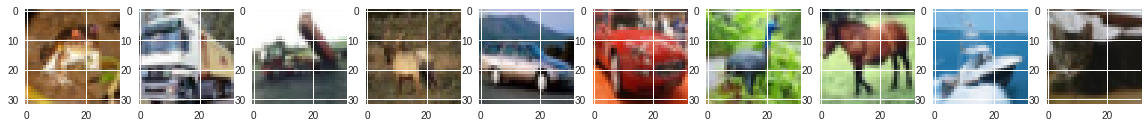

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [ ]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

Но pytorch требует, чтобы этот канал шёл на первом месте. То есть, мы имеем сейчас 4-мерный тензор: "количество картинок, высота, ширина и цвет", а Pytorch хочет: "количество картинок, количество цветов, ширина, высота". И теперь нам нужно реорганизовать размерность нашего тензора таким образом, чтобы цвет шёл на втором месте -- как раз после количества картинок в датасете. Это делается с помощью метода "permute". Вот здесь у нас permute с четырьмя аргументами. Первый аргумент "0" отвечает за количество картинок в нашем датасете. Мы не хотим, чтобы "количество картинок" в датасете поменяло позицию, соответственно тут стоит ноль. Далее стоит число "3" -- это значит, что на это место придёт размерность, которая была под номером "3" в изначальном тензоре, то есть это будет "количество каналов". Далее идёт "1", то есть на это место придёт "высота картинки", а дальше "2" -- это значит -- на это место придёт "ширина картинки", и у нас, после выполнения этой операции, у всего датасета будет shape: 50 000 на 3 на 32 на 32. то есть "каналы" будут идти перед размерностью изображения.

In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [ ]:
X_train.shape

torch.Size([50000, 3, 32, 32])

Далее -- мы изменим нашу сеть LeNet таким образом, чтобы она принимала изображения 32 на 32 и три канала на входе. Чтобы передать ей три канала, нужно в in_chanels первой же конволюции поставить "3" (раньше у нас тут было "1"). А вот размерность 32 на 32 у нас получается из паддинга. Как вы помните, в оригинальном LeNet была размерность 32 на 32 и там были нулевые паддинги, то есть конволюции не выходили за изображение. Мы специально, в LeNet, для MNIST это изменяли, чтобы у нас первая конволюция выходила за изображение и после первой конволюции получается разрешение 28 на 28. А теперь мы, наоборот, хотим чтобы паддинга не было, и из размерности 32 на 32 получалась размерность 28 на 28. Соответственно, мы поставим паддинг "0". Больше ничего не меняется -- процесс обучения не изменяется, он остался таким же, как и раньше.

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [1]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

Давайте посмотрим на результаты. Теперь у нас явно есть отличия в результатах. LeNet, изначальный -- с тангненсами, без свёрток 3 на 3, без max pooling и без батч-нормализации получает самые плохие показатели качества. Он обучается примерно на 55% accuracy, то есть он угадывает в 55% процентах случаев. Напомню, что классов 10, поэтому это не самое плохое качество. Если бы он угадывал случайно, то, наверное, было бы качество "0.1". На втором месте идут LeNet, в которых мы изменили активации -- сделали там активации ReLU. Это дало целых 5% качества. Кроме того, мы видим, что -- используем мы ReLU с 3 на 3 или 5 на 5 -- нет никакой разницы (зелёная линия -- это 5 на 5, красная -- это две свёртки 3 на 3). Кроме того, мы видим, что max pooling добавляет нам ещё целых 5% качества. То есть max pooling, по сравнению с average pooling, на данной задаче получает очень большой boost в качестве. И, в принципе, на любой задаче связанной с изображениями у вас будет так же. И, кроме того, мы видим интересную особенность батч-нормализации: сетка с батч-нормализацией учится очень быстро. Тот эффект, который мы и хотели от батч-нормализации -- ускорение обучения. 

Мы видим, что уже на пятой эпохе сетка достигает качества, которое без батч-нормализации достигается на 20-й эпохе. То есть, у нас получается ускорение в четыре раза. Но, кроме того, мы видим также, что батч-нормализация и переобучается быстрее. Логично предположить, что если весь процесс обучения ускоряется, то и момент переобучения наступает быстрее.

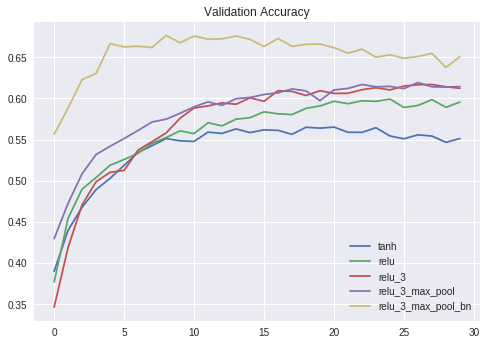

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

Более явно это можно увидеть на графиках лосс-функции, в которых очевидно, что переобучение при батч-нормализации наступает уже на пятой эпохе и качество начинает ухудшаться. Очень интересный вопрос: почему качество ухудшается так сильно -- на графиках сетка всё ещё лучше предсказывает, чем, например стандартный LeNet с тангенсом. Ведь тут мы по валидации очень сильно перепрыгнули тангенс, то есть мы предсказывали гораздо хуже. Дело в том, что переобученные сетки -- они очень уверены в своих ответах. То есть, если мы берём сеть, не переобученную, и она предсказывает неправильно с вероятностью 0.6, то переобученная сетка будет предсказывать неправильно с вероятностью "1", и, соответственно, её кросс-энтропия будет огромной. Здесь мы видим то же самое. На этом графике можно увидеть ещё одну контринтуитивную вещь. Если посмотреть на красную и зеленую кривые, то видно, что красная кривая переобучается, а зелёная ещё недообучена. Но красная кривая отвечает за две свёртки 3 на 3, а зелёная -- за одну свёртку 5 на 5, то есть мы хотели двумя свёртками 3 на 3 уменьшить количество весов и уменьшить возможность сетки для переобучения, а сделали наоборот. И из этого можно сделать вывод, что все рекомендации являются некоторыми эмпирическими фактами, которые могут не воспроизводиться на конкретно вашей задаче, на вашем датасете.

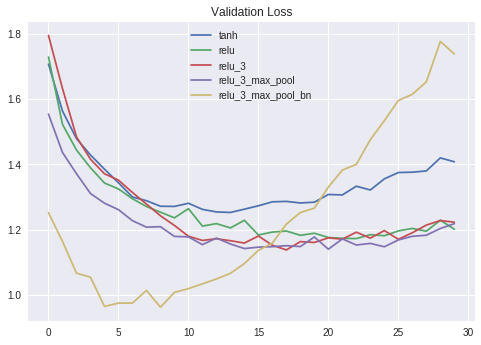

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

Несмотря на то, что получилось неплохо улучшить результат LeNet на датасете CIFAR -- мы улучшили результат на целых 10%, реализация LeNet имела очень большой недостаток. Она хорошо справлялась с цифрами в одноканальном изображении -- цифры были очень простые. А вот на датасете с тремя каналами и с довольно сложными картинками она уже справлялась плохо. Это происходило из-за того, что фильтров в наших свёртках было очень мало. Если вы помните, то первая свёртка имела всего 6 фильтров, а вторая 16. А дальше всё это переходило в полносвязанные слои. Так вот, давайте добавим фильтров и посмотрим -- а если мы из изображения будем извлекать больше информации, может быть, и качество станет лучше. Возьмём все идеи из предыдущего шага и поместим их в одну лаконичную сеть -- назовём её "CIFARNet". Наша сеть будет обладать батч-нормализациями, активации там будут ReLU, мы будем использовать конволюции 3 на 3. В принципе, мы можем использовать конволюции 5 на 5, чтобы узнать, как сделать лучше: я вас призываю попробовать самостоятельно. Кроме того, наши конволюции будут выходить за размер изображения, чтобы этот размер не менялся до и после конволюции. В принципе, зачастую, это хорошая идея, потому что таким образом сеть понимает -- а где границы изображения, в каком месте конволюция находятся в данный момент, находится она в углу изображения, слева или справа. Потому что пиксели, которые выходят за размер изображения заполняются нулями: соответственно, можно обучить такие конволюции, которые будет реагировать на границы изображения и, может быть, это -- дополнительная информация, которая раньше не была доступна. Давайте пройдемся по конкретной реализации. Сперва мы применим батч-нормализацию к исходному изображению -- в принципе, такую батч-нормализацию можно трактовать как нормировку по яркости и контрасту изначального изображения. Дальше мы будем применять свёртки, каждая свёртка будет 3 на 3. Первая свёртка будет иметь 16 каналов (из 3 каналов превращается в 16 каналов). Эта свёртка будет выходить на 1 за размер изображения, из чего следует, что изображение после этой свёртки останется в старом размере. Далее -- активация ReLU, опять батч-нормализация и max pooling. И вот такие вот блоки: конволюция, активация, нормализация и max-pooling будут у нас повторяться. Второй блок отличается от первого только тем, что на вход приходят к нему 16 каналов а на выходе -- 32. Соответственно, каждый следующий блок будет увеличивать в два раза количество каналов. Третий блок: 32 канала на вход, 64 на выход. После третьей свёртки, точно так же, как мы делали в LeNet, у нас будет три полносвязанных слоя. Первый полносвязанный слой примет растянутый вектор изображения размером 8 на 8 на 64. Это число -- 4096: 8 на 8 обусловлено размером тензора, который пришёл после последней свёртки, а 64 -- это её количество каналов. Этот большой тензор он ужмёт в вектор размером 56. Далее будет активация тангенсом. В принципе, можно было бы оставить ReLU -- это на ваше усмотрение. Далее -- BatchNorm1d, потому что у нас 1D тензор. На вход ему приходит 56, потому что это количество нейронов. И далее, точно так же, один полносвязанный слой ужимает до 64 нейронов, тангенс в качестве активации и BatchNorm1d. И последний -- из 64 нейронов делает 10, которые являют собой ответ. Функция forward повторяет логику нашей инициализации. Мы применяем BatchNorm, который называется "batch_norm0", потому что он применяется к изначальному изображению. Далее: конволюция, активация, батч-норм, пулинг; конволюция, активация, батч-норм, пулинг (второй блок); и снова конволюция, активация, "batch_norm3" -- в принципе, можно было бы тоже сделать пулинг -- на ваше усмотрение, можете попробовать с ним. Далее мы разворачиваем наши тензоры в батч из векторов. Первым идёт batch_size, потом размер вектора, который мы хотим получить. То есть это будет: "x.size" -- это 8: высота изображения; "x.size(2)" -- это тоже 8: это ширина изображения, и "x.size(3)" -- это 64: количество каналов в тензоре, которое приходит из последней свёртки. Далее идёт fully-connected слой, активация, batchnorm; fully-connected слой, активация, batchnorm; и ответы получаются из последнего, третьего fully-connected слоя. Давайте посмотрим, как эта сеть классифицирует изображения.

In [ ]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

In [2]:
accuracies['cifar_net'], losses['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)

На графике validation accuracy мы видим, что наша новая сеть, которую мы назвали CIFARNet, побеждает все предыдущие реализации. И, видимо, это происходит из-за того, что у неё больше фильтров в конволюциях. Давайте посмотрим ещё графики лоссов, и на этом графике видно, что после 3-й эпохи обучать сеть уже бессмысленно, она не улучшается по качеству, но её уверенности становятся более категоричными. То есть сеть становится более уверена даже в своих неправильных предсказаниях, из-за чего график лосса сильно растёт.

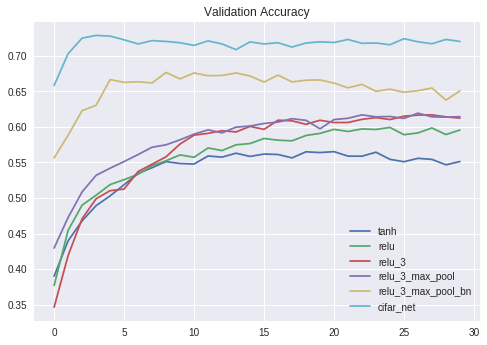

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

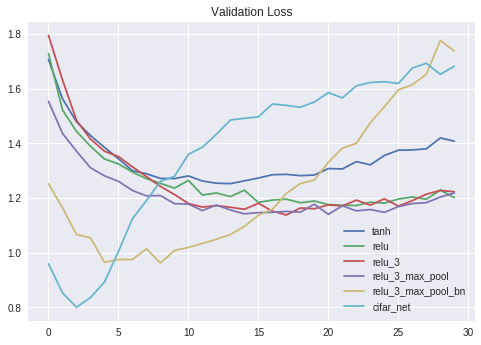

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

Резюмируя: на этом семинаре мы научились работать с конволюционными нейронными сетями. Мы получили некоторую интуицию, как влияют на сеть разные функции активации, разные пулинги, что будет, если добавить в нейронную сеть батч-нормализации, как влияют различные свёртки. Мы видим, что в разных датасетах, в разных задачах, возможно, подходят разные свёртки. И мы увидели на практике, что такое переобучение, почему необязательно сеть нужно обучать бесконечно долго, почему нужно останавливаться. В принципе, мы могли бы сюда добавить ещё такие слои как DropOut, мы могли бы добавить сюда регуляризацию, и посмотреть, а как влияет это всё на обучение сети.

Проверим утверждение про затухание градиента на практике. В [документации](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) pytorch можно найти следующие функции активации (самые популярные мы наклонили): 

*ELU*, Hardtanh, *LeakyReLU*, LogSigmoid, PReLU, *ReLU*, ReLU6, RReLU, SELU, CELU, *Sigmoid&, Softplus, Softshrink, Softsign, *Tanh*, Tanhshrink, Hardshrink.

Вам предстоит найти активацию, которая приводит к наименьшему затуханию градиента. 

Для проверки мы сконструируем SimpleNet, которая будет иметь внутри 3 fc-слоя, по 1 нейрону в каждом без bias'ов. Веса этих нейронов мы проинициализируем единицами. На вход в эту сеть будем подавать числа из нормального распределения. Сделаем 200 запусков (NUMBER_OF_EXPERIMENTS) для честного сравнения и посчитаем среднее значение градиента в первом слое. Найдите такую функцию, которая будет давать максимальные значения градиента в первом слое. Все функции активации нужно инициализировать с аргументами по умолчанию (пустыми скобками).

In [4]:
import torch
import numpy as np

seed = 11
np.random.seed(seed)
torch.manual_seed(seed)

NUMBER_OF_EXPERIMENTS = 200

class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False)  # one neuron without bias
        self.fc1.weight.data.fill_(1.)  # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)

def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward()  # no loss function. Pretending that we want to minimize output
                       # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad


In [5]:
activations =  {'ELU': torch.nn.ELU(), 'Hardtanh': torch.nn.Hardtanh(),
               'LeakyReLU': torch.nn.LeakyReLU(), 'LogSigmoid': torch.nn.LogSigmoid(),
               'PReLU': torch.nn.PReLU(), 'ReLU': torch.nn.ReLU(), 'ReLU6': torch.nn.ReLU6(),
               'RReLU': torch.nn.RReLU(), 'SELU': torch.nn.SELU(), 'CELU': torch.nn.CELU(),
               'Sigmoid': torch.nn.Sigmoid(), 'Softplus': torch.nn.Softplus(),
               'Softshrink': torch.nn.Softshrink(), 'Softsign': torch.nn.Softsign(),
               'Tanh': torch.nn.Tanh(), 'Tanhshrink': torch.nn.Tanhshrink(),
               'Hardshrink': torch.nn.Hardshrink()}


In [6]:
%%time

result = dict()

for name, activation in activations.items():
    np.random.seed(11)
    torch.manual_seed(11)
    net = SimpleNet(activation=activation)
    
    fc1_grads = []
    for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
        fc1_grads.append(get_fc1_grad_abs_value(net, x))
    result[name] = fc1_grads

CPU times: user 1.95 s, sys: 30.8 ms, total: 1.98 s
Wall time: 2.07 s


In [7]:
mean = [(np.mean(lst), name) for name, lst in result.items()]

In [8]:
sorted(mean, reverse=True)[0]

(0.737217696905136, 'Hardshrink')

In [13]:
import torch
import numpy as np
from torch.nn import *

seed = int(11)
np.random.seed(seed)
torch.manual_seed(seed)

NUMBER_OF_EXPERIMENTS = 200

class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False)  # one neuron without bias
        self.fc1.weight.data.fill_(1.)  # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)

def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward()  # no loss function. Pretending that we want to minimize output
                       # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad

activations_list = ['ELU', 'Hardtanh', 'LeakyReLU', 'LogSigmoid', 
                    'PReLU', 'ReLU', 'ReLU6', 'RReLU', 'SELU', 
                    'CELU', 'Sigmoid', 'Softplus', 'Softshrink', 
                    'Softsign', 'Tanh', 'Tanhshrink', 'Hardshrink']
values_list = []

for name in activations_list:
    np.random.seed(seed)
    torch.manual_seed(seed)
    activation = getattr(torch.nn, name)()
    net = SimpleNet(activation=activation)
    fc1_grads = []
    for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
        fc1_grads.append(get_fc1_grad_abs_value(net, x))
    values_list.append(np.mean(fc1_grads))

print(np.max(values_list))

0.737217696905136


In [14]:
# Имеет смысл посмотреть на наилучший метод:

best_funct_idx = values_list.index(max(values_list))
best_funct_name = activations_list[best_funct_idx]
print(getattr(torch.nn, best_funct_name)())

Hardshrink(0.5)


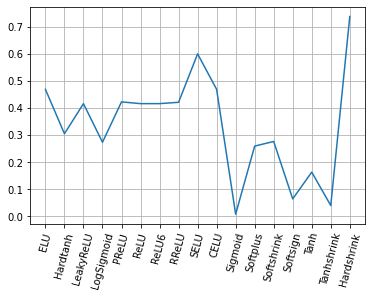

In [17]:
# Наглядно на графике:

import pandas as pd
from matplotlib import pylab as plt
plt.xticks(range(len(df.index)), df.index);
%matplotlib inline
df = pd.Series(values_list, index=activations_list);
plt.xticks(range(len(df.index)), df.index);
df.plot(rot=75, grid=True);



Попробуйте решить следующую задачу пользуясь только бумагой и калькулятором:

Допустим, у нас есть нейросеть, состоящая из 4-х полносвязных слоев, в каждом из которых по одному нейрону. Для простоты будем считать, что bias'ы у нейронов отсутствуют, а все веса равны 1.

После каждого слоя мы поставим активации. В первом случае это будут tanh, во втором - ReLU. Не будем добавлять никакую loss-функцию. Тогда нашу сеть можно будет записать в виде функции:

$f = a_4(w_4 \cdot a_3(w_3 \cdot a_2(w_2 \cdot a_1(w_1 \cdot x))))$ 

Где $a$ - это либо tanh либо $ReLU$. $w_i$ - это одно число.

Пусть на вход подали x=100

Зная, что $tanh'(x) = 1 - tanh^2(x)$, рассчитайте градиенты весов сети:$[f'_{w_1}, f'_{w_2}, f'_{w_3}, f'_{w_4}, ]$ для случая $a=tanh$ и для случая $a=ReLU$ . Результат округлите до 3-го знака.

Формат ответа:

$[1234.123, 123.12, 123.1, 123.0], [0.0, 0.1, 0.12, 0.123]$

Правда ли, что для активаций гиперболическим тангенсом, градиенты затухают быстрее?


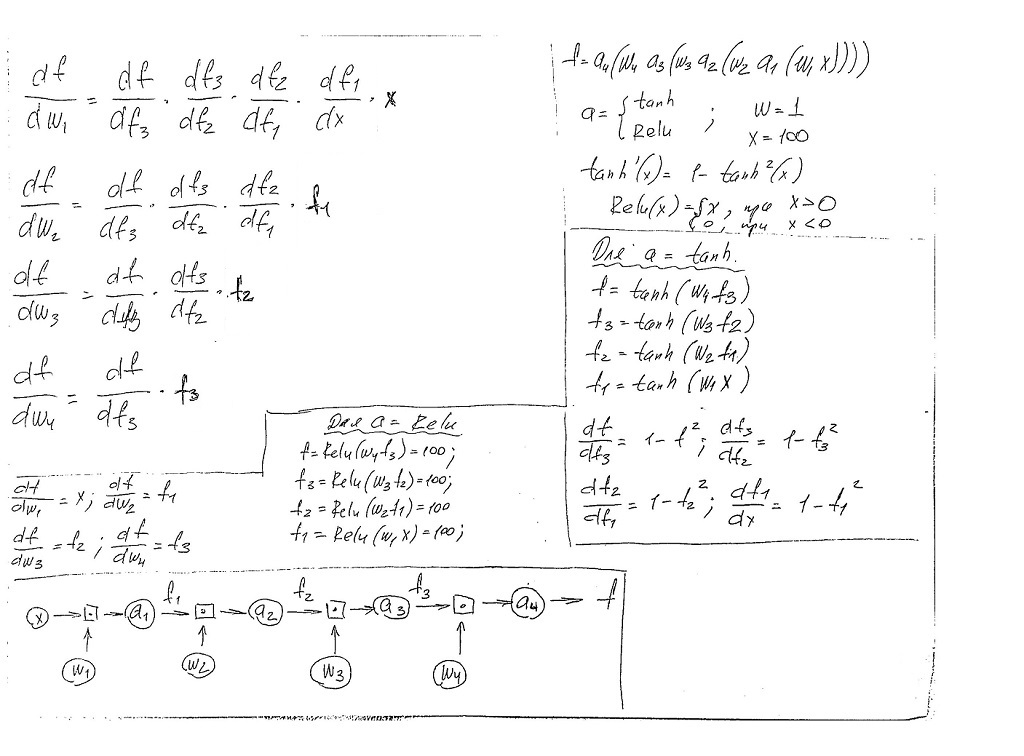

In [25]:
from numpy import tanh
import numpy as np

relu = lambda x: max(0, x)
x = 100
der_act_tanh = lambda x: 1 - tanh(x)**2
der_act_relu = lambda x: 1 if x > 0 else 0
def get_grad(a, der):
    z1 = x
    z2 = a(z1)
    z3 = a(z2)
    z4 = a(z3)
    df_dw4 = der(z4)*a(z3)
    df_dw3 = der(z4)*der(z3)*a(z2)
    df_dw2 = der(z4)*der(z3)*der(z2)*a(z1)
    df_dw1 = der(z4)*der(z3)*der(z2)*der(z1)*x
    return (df_dw1, df_dw2, df_dw3, df_dw4)
print(get_grad(tanh, der_act_tanh))
print()
print(get_grad(relu, der_act_relu))

(0.0, 0.16770685876939032, 0.3041246830975466, 0.436145382444544)

(100, 100, 100, 100)


# Проблема затухающего градиента в НС

Рассмотрим задачу где есть:

    НС с 4 слоями
    1 слой - 1 нейрон

    Формула НС $f = a_4(w_4*a_3(w_3*a_2(w_2*a_1(w_1*x))))$

    где:
        $f$ - выход из НС
        $x$ - входной скаляр
        $w_n$ - веса $n$-ного слоя
        $a_n$ - нелинейная функция активации на $n$-ном слое

    Требуется найти градиент по всем $w_n$

    если:
        $a_n = Tanh()$
        $a_n = ReLU()$

# Разложим формулу и применим правило цепочки:

$f_1 = tanh(w_1*x)$

$f_2 = tanh(w_2*f_1)$

$f_3 = tanh(w_3*f_2)$

$f = tanh(w_4*f_3)$

$\frac{d(f)}{d(w_4)} = \frac{d(f)}{d(f_3)} * f_3$

$\frac{d(f)}{d(w_3)} = \frac{d(f)}{d(f_3)} * \frac{d(f_3)}{d(f_2)} * f_2$

$\frac{d(f)}{d(w_2)} = \frac{d(f)}{d(f_3)} * \frac{d(f_3)}{d(f_2)} * \frac{d(f_2)}{d(f_1)} * f_1$

$\frac{d(f)}{d(w_1)} = \frac{d(f)}{d(f_3)} * \frac{d(f_3)}{d(f_2)} * \frac{d(f_2)}{d(f_1)} * \frac{d(f_1)}{d(x)} * x$

$tanh'(x) = 1 - tanh^2(x)$

Решение
Для начала импортируем $tanh$ 

In [26]:
from numpy import tanh

# Инициализируем $x$ и $w$

In [27]:
x = 100
w_1, w_2, w_3, w_4 = [1,1,1,1]

In [28]:
f_1 = tanh(w_1*x)
f_2 = tanh(w_2*f_1)
f_3 = tanh(w_3*f_2)

In [29]:
grad_w4 = (1-tanh(f_3)**2)*f_3
grad_w3 = (1-tanh(f_3)**2)*(1-tanh(f_2)**2)*f_2
grad_w2 = (1-tanh(f_3)**2)*(1-tanh(f_2)**2)*(1-tanh(f_1)**2)*f_1
grad_w1 = (1-tanh(f_3)**2)*(1-tanh(f_2)**2)*(1-tanh(f_1)**2)*(1-tanh(x)**2)*x

# Создадим функцию для вывода информации

In [30]:
def show(fn_act,grads_w):
    print(fn_act)
    for n, grad in enumerate(grads_w):
        print(f"\tГрадиент W на {n+1} слое:\t{grad}")

# Выведем информацию

In [31]:
show("Tanh:",(grad_w1,grad_w2,grad_w3,grad_w4))

Tanh:
	Градиент W на 1 слое:	0.0
	Градиент W на 2 слое:	0.16770685876939032
	Градиент W на 3 слое:	0.3041246830975466
	Градиент W на 4 слое:	0.436145382444544


# Теперь посчитаем это с помощью PyTorch-autograd

In [32]:
import torch
from torch.nn import Tanh, ReLU

In [33]:
sclr = lambda v: torch.tensor(v,requires_grad=True)
x = sclr(100.)
w_1, w_2, w_3, w_4 =  [sclr(1.) for _ in range(4)]

In [34]:
for a in [Tanh(),ReLU()]:
    f = lambda x: a(w_4 * a(w_3 * a(w_2 * a(w_1 * x))))
    y = f(x)
    y.backward()
    show(a,(w_1.grad,w_2.grad,w_3.grad,w_4.grad))
    for var in [w_1.grad,w_2.grad,w_3.grad,w_4.grad]:
        var.zero_()

Tanh()
	Градиент W на 1 слое:	0.0
	Градиент W на 2 слое:	0.16770686209201813
	Градиент W на 3 слое:	0.30412471294403076
	Градиент W на 4 слое:	0.4361453950405121
ReLU()
	Градиент W на 1 слое:	100.0
	Градиент W на 2 слое:	100.0
	Градиент W на 3 слое:	100.0
	Градиент W на 4 слое:	100.0


# Вывод

Из данных наблюдений следует, что функция активации $Tanh$, которая активно

применялась в LeNet(1998), в некоторых ситуациях, сильно способствует затуханию градиента.

Что в свою очередь, делает почти что, невозможным её примение в глубоких НС.
